# 1. Electrical Energy Prediction EDA

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


In [6]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import itertools
from tqdm import tqdm


## 1-1. Load Data

In [7]:
train = pd.read_csv("./train.csv", encoding='cp949')
test = pd.read_csv("./test.csv", encoding = "cp949")
submission = pd.read_csv("./sample_submission.csv", encoding = "cp949")

In [8]:
# 데이터 상단 출력
display(train.head)

<bound method NDFrame.head of         num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0         1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8   
1         1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3   
2         1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0   
3         1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0   
4         1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0   
...     ...            ...         ...     ...      ...    ...      ...   
122395   60  2020-08-24 19    4114.368    27.8      2.3   68.0      0.0   
122396   60  2020-08-24 20    3975.696    27.3      1.2   71.0      0.0   
122397   60  2020-08-24 21    3572.208    27.3      1.8   71.0      0.0   
122398   60  2020-08-24 22    3299.184    27.1      1.8   74.0      0.0   
122399   60  2020-08-24 23    3204.576    27.1      2.6   75.0      0.0   

        일조(hr)  비전기냉방설비운영  태양광보유  
0          0.0        0.0    0.0  

In [9]:
# 데이터 상단 출력
display(test.head)

<bound method NDFrame.head of        num      date_time  기온(°C)  풍속(m/s)  습도(%)  강수량(mm, 6시간)  일조(hr, 3시간)  \
0        1  2020-08-25 00    27.8      1.5   74.0           0.0          0.0   
1        1  2020-08-25 01     NaN      NaN    NaN           NaN          NaN   
2        1  2020-08-25 02     NaN      NaN    NaN           NaN          NaN   
3        1  2020-08-25 03    27.3      1.1   78.0           NaN          0.0   
4        1  2020-08-25 04     NaN      NaN    NaN           NaN          NaN   
...    ...            ...     ...      ...    ...           ...          ...   
10075   60  2020-08-31 19     NaN      NaN    NaN           NaN          NaN   
10076   60  2020-08-31 20     NaN      NaN    NaN           NaN          NaN   
10077   60  2020-08-31 21    27.9      4.1   68.0           NaN          0.0   
10078   60  2020-08-31 22     NaN      NaN    NaN           NaN          NaN   
10079   60  2020-08-31 23     NaN      NaN    NaN           NaN          NaN   

       비전

In [10]:
# 데이터 상단 출력
display(submission.head)

<bound method NDFrame.head of           num_date_time  answer
0       1 2020-08-25 00       0
1       1 2020-08-25 01       0
2       1 2020-08-25 02       0
3       1 2020-08-25 03       0
4       1 2020-08-25 04       0
...                 ...     ...
10075  60 2020-08-31 19       0
10076  60 2020-08-31 20       0
10077  60 2020-08-31 21       0
10078  60 2020-08-31 22       0
10079  60 2020-08-31 23       0

[10080 rows x 2 columns]>

In [11]:
# 데이터 크기 확인
display(train.shape, test.shape)

(122400, 10)

(10080, 9)

🌳 10080 * 9 => 60개 건물 * 7일 * 24시간 = 10080

In [12]:
# 데이터 형식 확인
train.dtypes

num             int64
date_time      object
전력사용량(kWh)    float64
기온(°C)        float64
풍속(m/s)       float64
습도(%)         float64
강수량(mm)       float64
일조(hr)        float64
비전기냉방설비운영     float64
태양광보유         float64
dtype: object

In [13]:
# 데이터 형식 확인
test.dtypes

num               int64
date_time        object
기온(°C)          float64
풍속(m/s)         float64
습도(%)           float64
강수량(mm, 6시간)    float64
일조(hr, 3시간)     float64
비전기냉방설비운영       float64
태양광보유           float64
dtype: object

In [14]:
# 데이터 기초통계량 확인
display(train.describe())

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


## 1-2. Data Wrangling

1-2-1. 중복값 확인

In [15]:
# removing duplicates
sum(train.duplicated()), sum(test.duplicated())


(0, 0)

1-2-2. Null 확인

In [16]:
train.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [17]:
test.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

# 2. ARIMA(p,d,q)

- 자기회귀누적이동평균모형 (Autoregressive integrated moving average model)

- 비정상 시계열 모형
- AR모형 + MA 모형 합쳐 정상화할 수 있음

- p: AR의 차수
- q: MA의 차수
- d: 차분의 정도
  => d차 차분은 아래와 같이 연이은 관측값의 차이를 d번 한 것

  예1) **d=0이면, ARMA(p,q)모형이라 부르고 이 모형은 정상성을 만족한다.**

  예2) p=0이면, IMA(d,q)모형이라 부르고 d번 차분하면 MA(q)모형을 따르게 된다.

  예3) q=0이면, ARI(p,d)모형이라 부르며, d번 차분한 시계열이 AR(p)모형을 따르게 된다.

### ▪️ 자기회귀 모형(AR모형)
- 시계열 값이 과거 p시점만큼 앞선 시점까지의 값에 의존할 때 쓰는 모형으로, 현 시점의 값을 자기 자신의 과거의 값들로 설명하는 회귀모형

- 자기회귀모델의 경우, 데이터는 그 데이터 자신의 과거의 값 외에 잡음이 섞여 데이터가 결정되어 있다고 보는 것에서 시작됨

  예) 충격이 없을때 손님이 30명인데, 내일 충격으로 인해 24.6명~ 33.4명의 범위가 될 것이라고 추정함.

---

### ▪️ 이동평균 모형(MA모형)
-  시계열 값이 과거 q시점만큼 앞선 시점까지의 오차에 의존할 때 쓰는 모형으로, 현 시점의 값을 과거의 오차 값들로 설명하는 회귀모형

- 이동평균 모형의 경우,충격에 의해 데이터가 일시적으로 정상값과 떨어저서 그것이 다시 정상값으로 향하는 움직임을 표현함.

    예) 손님수가 주변에서 축제가 있으면 당일에 고객수가 늘어나는 반면, 다음날과 그 다음 날에는 반동으로 손님수가 줄어는 경우가 존재함. => 어느 날의 충격이 그 둘째 날까지 영향을 남긴다고 하는 점에서 MA(2)모델을 추정하여 손님수를 예상하면 된다.



In [18]:
#2d의 데이터프레임을 건물별 정보를 반영한 3d 데이터로 변환
def df2d_to_array3d(df_2d):

    # feature 사이즈 : 행 전체, 열 index2 부터 가져온 df의 shape를 구함 => (행, 열) 그중에 index1 가져옴 = 열 사이즈
    feature_size = df_2d.iloc[:,2:].shape[1]
    #print(feature_size)

    # 타임사이즈 : 날짜의 개수를 구함
    time_size=len(df_2d['date_time'].value_counts())

    # 샘플(건물)사이즈 : num행의 개수를 구함
    sample_size=len(df_2d.num.value_counts())
    #print(df_2d.num.value_counts())

    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    #print(df_2d.iloc[:,2:].values.shape) # Data by columns
    print(df_2d.iloc[:,2:].values.reshape([sample_size,time_size,feature_size]).shape)

train_x_array=df2d_to_array3d(train)
test_x_array=df2d_to_array3d(test)

In [19]:
# 기존 : 2차 행렬 => reshape : 3차 행렬

# (건물 60개, 날짜 2040개/건물, 피처 8개/건물.날짜)
print(train_x_array.shape)

# (건물 60개, 날짜 168개/건물, 피처 7개/건물.날짜)
print(test_x_array.shape)

(60, 2040, 8)
(60, 168, 7)


In [73]:
# df 형태: (건물 60개, 날짜 2040개/건물, 피처 8개/건물.날짜)
idx=1

# 건물 60개 중 1개의 날짜별 전력사용량
x_series=train_x_array[idx, :, 0]

# print(x_series)

최적 차분수 구하기

In [74]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(x_series, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(x_series, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 1


In [75]:
# 최적의 파라미터를 찾기 위해서 grid search 진행
# ARIMA의 AR(자기회귀): p, 차분: d, MA(이동평균):q
p = q = range(0,5)
d = range(0,1)

# grid 생성
pdq = list(itertools.product(p,d,q))

# AIC 값 담을 곳
aic = []
# 파라미터 담을 곳
params = []


with tqdm(total = len(pdq)) as pg:
  for i in pdq:
    pg.update(1)
    try:
        model = ARIMA(x_series, order=(i))
        # 모델 학습
        fit = model.fit()
        aic.append(round(fit.aic,2))
        params.append((i))

    except:
        continue

  8%|▊         | 2/25 [00:00<00:04,  5.59it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 72%|███████▏  | 18/25 [00:32<00:12,  1.79s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 92%|█████████▏| 23/25 [00:50<00:06,  3.16s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 25/25 [01:01<00:00,  4.53s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [83]:
# 탐색된 파라미터들 중 aic가 가장 낮은 모델을 최적의 모델로 선정
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]

optimal

[((2, 0, 4), 22992.15)]

In [79]:
model_opt = ARIMA(x_series, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2040
Model:                 ARIMA(2, 0, 4)   Log Likelihood              -11488.077
Date:                Tue, 30 Jan 2024   AIC                          22992.154
Time:                        11:51:35   BIC                          23037.119
Sample:                             0   HQIC                         23008.648
                               - 2040                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1299.9142     15.862     81.954      0.000    1268.826    1331.002
ar.L1          1.8515      0.023     81.808      0.000       1.807       1.896
ar.L2         -0.9073      0.019    -46.660      0.000      -0.945      -0.869
ma.L1         -0.2283      0.031     -7.279      0.000      -0.290      -0.167
ma.L2         -0.3193      0.029    -11.036      0.000      -0.376      -0.263
ma.L3         -0.1697      0.029     -5.926      0.000      -0.226      -0.114
ma.L4          0.1719      0.030      5.756      0.000       0.113       0.230
sigma2      4530.2915    111.300     40.703      0.000    4312.147    4748.436
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):              2346.98
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
# 모델 예측
# 1부터 168까지 총 168개 값(start, end)
# typ='levels' : 학습에 input된 값과 동일한 값을 예측
# predict(start=None, end=None, typ= ['linear','levels'] )

pred = fit.predict(0, 167, typ='levels')

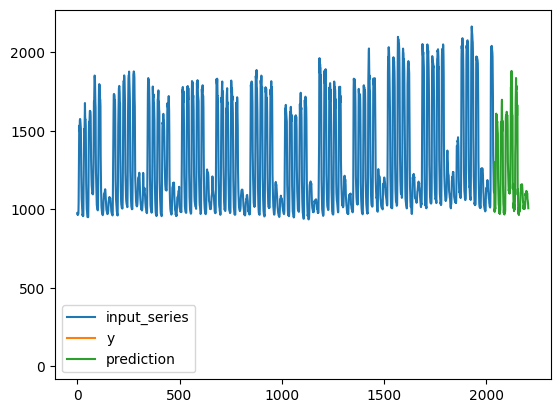

In [41]:
# 그래프 그리기
plt.plot(x_series, label = 'input_series')

plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')

plt.plot(np.arange(2040, 2040+168), pred, label='prediction')

plt.legend()

## 3. SARIMA
- ARIMA에서 데이터의 주기성을 추가로 고려해주는 모델
- 데이터가 1시간의 간격으로 존재하기 때문에 24로 설정

In [ ]:
# 최적의 파라미터를 찾기 위해서 grid search 진행
# ARIMA의 AR(자기회귀): p, 차분: d, MA(이동평균):q
p = range(0,5)
d = range(1)
q = range(0,5)
m = 24

# grid 생성
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p,d,q))]

# AIC 값 담을 곳
aic = []
# 파라미터 담을 곳
params = []


with tqdm(total = len(pdq)) as pg:
  for i in pdq:
    for j in seasonal_pdq:
      pg.update(1)
      try:
          model = SARIMAX(x_series, order=(i), season_order = (j))
          # 모델 학습
          fit = model.fit()
          aic.append(round(fit.aic,2))
          params.append((i))

      except:
          continue

  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['season_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
193it [01:21,  1.21it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
449it [07:59,  2.04s/it]

Auro ARIMA를 통한 모델링

In [42]:
# 예시
example_model = pm.auto_arima(y = x_series,		# 데이터
                      d = 1,	# 차분 (d), 기본값 = None
                      start_p = 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q = 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m = 24,			# season의 주기, 기본값 = 1
                      seasonal = False,	# sARIMA를 실시, 기본값 = True
                      stepwise = True,	# stepwise algorithm, 기본값 = True
                      trace = True)		# 각 step을 출력할지, 기본값 = False

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24650.745, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23392.195, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23647.505, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24648.746, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23318.558, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23319.499, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23319.959, Time=1.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23323.505, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23320.251, Time=2.78 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23316.559, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23390.195, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=23317.499, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23317.959, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23321.505, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0

In [81]:
model = ARIMA(x_series, order=(2,1,0))
# 모델 학습
fit2 = model.fit()

pred_model=fit2.predict(1, 168, typ='levels')

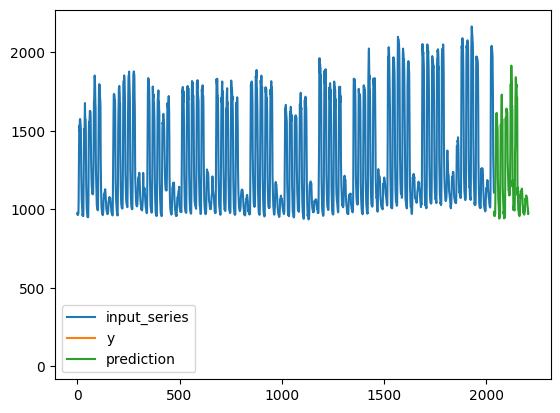

In [82]:
# 그래프 그리기
plt.plot(x_series, label = 'input_series')

plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')

plt.plot(np.arange(2040, 2040+168), pred_model, label='prediction')

plt.legend()

In [86]:
model_opt2 = ARIMA(x_series, order = (2,1,0))
model_opt_fit2 = model_opt2.fit()
model_opt_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2040
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -11655.279
Date:                Tue, 30 Jan 2024   AIC                          23316.559
Time:                        11:53:50   BIC                          23333.419
Sample:                             0   HQIC                         23322.743
                               - 2040                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8085      0.017     47.669      0.000       0.775       0.842
ar.L2         -0.1908      0.022     -8.695      0.000      -0.234      -0.148
sigma2      5404.9878     94.753     57.043      0.000    5219.275    5590.701
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              2171.50
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. Auto ARIMA

In [87]:
cal_model2 = pm.auto_arima(x_series, d=1, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23305.081, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24650.745, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23392.195, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23647.505, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24648.746, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23309.809, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23319.959, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23303.773, Time=3.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23320.251, Time=1.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=23304.820, Time=6.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=23305.386, Time=3.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=23307.265, Time=1.44 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.69 sec
 ARIMA(3,1,2)(0,0,0)[0]        

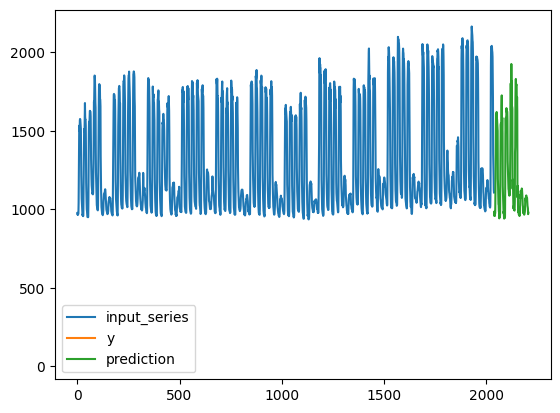

In [89]:
model = ARIMA(x_series, order=(3,1,2))
# 모델 학습
fit3 = model.fit()

pred_model2=fit3.predict(1, 168, typ='levels')

# 그래프 그리기
plt.plot(x_series, label = 'input_series')

plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')

plt.plot(np.arange(2040, 2040+168), pred_model2, label='prediction')

plt.legend()

In [90]:
model_opt2 = ARIMA(x_series, order = (2,1,0))
model_opt_fit2 = model_opt2.fit()
model_opt_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2040
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -11655.279
Date:                Tue, 30 Jan 2024   AIC                          23316.559
Time:                        11:55:15   BIC                          23333.419
Sample:                             0   HQIC                         23322.743
                               - 2040                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8085      0.017     47.669      0.000       0.775       0.842
ar.L2         -0.1908      0.022     -8.695      0.000      -0.234      -0.148
sigma2      5404.9878     94.753     57.043      0.000    5219.275    5590.701
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              2171.50
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SMAPE 계산

In [91]:
# SMAPE 정의
def smape(real, pred):
  return np.mean((np.abs(real-pred))/(np.abs(real) + np.abs(pred))) * 100

smape(x_series, pred)

In [93]:
# idx를 train_x_array의 행 숫자만큼 진행
print(train_x_array.shape[0])

60


In [92]:
# 2D zero matrix 만들어줌 (건물 수, 날짜 수)
valid_pred_array=np.zeros([60, 168])
# idx를 건물 수 만큼 반복(train_x_array의 행 숫자)
for idx in range(train_x_array.shape[0]):
    # for문으로 실행할 코드
    try:
        try:
            # idx번째 건물의 날짜별 전력사용량
            x_series=train_x_array[idx, :, 0]
            # AR: 2, 차분:0, MA: 4 의 ARIMA 모델 생성 => AIC 가장 작은 값
            model=ARIMA(x_series, order=(2,0,4))
            # 모델 학습
            fit=model.fit()

            # 모델 예측 (test 데이터 날짜 168개 만큼의 전력사용량을 예측)
            preds=fit.predict(1, 168, typ='levels')

            # idx번째 건물의 예측한 값을 idx 행에 저장
            valid_pred_array[idx, :]=preds

        # 예외가 발생했을 때 : AR=4로 바꿔서 학습
        except:
            # idx번째 건물의 날짜별 전력사용량
            x_series=train_x_array[idx, :, 0]
            # AR: 3, 차분:1, MA: 2 의 ARIMA 모델 생성 => AIC 두번째 작은 값
            model=ARIMA(x_series, order=(3,1,2))
            # 모델 학습
            fit=model.fit()

            # 모델 예측 (test 데이터 날짜 168개 만큼의 전력사용량을 예측)
            preds=fit.predict(1, 168, typ='levels')

            # idx번째 건물의 예측한 값을 idx 행에 저장
            valid_pred_array[idx, :]=preds


    # 예외가 발생했을 때 실행
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

In [94]:
valid_pred_array.shape

valid_pred_array

array([[8192.1137719 , 8153.01653293, 8120.37033821, ..., 8626.64463024,
        8621.15073732, 8616.24684966],
       [ 991.85196844,  984.27159149, 1002.7794309 , ..., 1037.67487653,
        1004.62001404, 1012.30102163],
       [3212.1038111 , 3202.92365779, 3211.22909911, ..., 3239.62481984,
        3232.76668692, 3232.07626268],
       ...,
       [ 600.71028288,  551.62332079,  557.55690795, ...,  665.09559002,
         641.49615318,  596.72276082],
       [ 699.0579509 ,  682.73001949,  837.20116746, ..., 1210.68826527,
        1185.15645771,  958.93882058],
       [2590.3743802 , 2270.68625418, 2387.07446342, ..., 3180.03800925,
        3027.04415649, 2937.19894133]])

In [95]:
# 3d배열 => 2d배열로 변경
# reshape([-1,1]) => 전체행을(마지막행 index: -1)를 1열로 변경
submission['answer']=valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,8192.113772
1,1 2020-08-25 01,8153.016533
2,1 2020-08-25 02,8120.370338
3,1 2020-08-25 03,8065.906601
4,1 2020-08-25 04,8053.295094
...,...,...
10075,60 2020-08-31 19,3144.793035
10076,60 2020-08-31 20,3133.260910
10077,60 2020-08-31 21,3180.038009
10078,60 2020-08-31 22,3027.044156


In [99]:
submission.to_csv('sample_submission.csv', index=False)